<center><h2>Brief Description of GMM</h2></center>

#### Under the hood, a Gaussian mixture model is very similar to k-means: it uses an expectation–maximization approach which qualitatively does the following:

1) Choose starting guesses for the location and shape

2) Repeat until converged:
    - E-step: for each point, find weights encoding the probability of membership in each cluster
    - M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights


The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model. Just as in the k-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

In [112]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture
import math

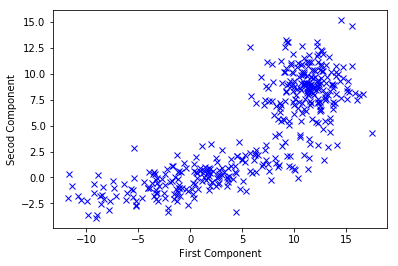

In [113]:
#import data using pandas
df = pd.read_csv('two_normal.csv')

#name of first column/component
comp1 = '0'
#name of second component
comp2 = '1'

plt.plot(df.loc[:,comp1], df.loc[:, comp2], 'bx')
plt.xlabel('First Component')
plt.ylabel('Secod Component');
plt.show()

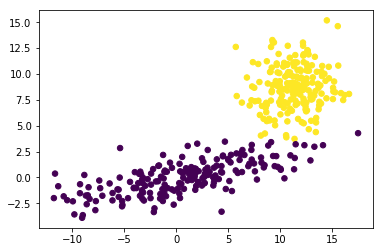

In [114]:
# fit a Gaussian Mixture Model with two components
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(df.loc[:,[comp1,comp2]])



labels = gmm.predict(df.loc[:,[comp1,comp2]])
#s denotes size of scatter points, cmap:colour-map
plt.scatter(df.loc[:,comp1], df.loc[:, comp2], c=labels, s=30, cmap='viridis');


In [115]:
def multivariate_gaussian(x, mu, cov):
    #Calculation of multivariate guassian pdf
    #x is the point, mu: list mean of all fields, 
    #cov: covariance matrix
    
    size = len(x)
#     print(size)
#     print(len(mu))
    
    if size == len(mu) and (size, size) == cov.shape:
        det = np.linalg.det(cov)
        if det == 0:
            raise NameError("The covariance matrix can't be singular")
        
        norm_const = 1.0/ ( math.pow((2*np.pi),float(size)/2) * math.pow(det,1.0/2) )
        x_mu = np.matrix(x - mu)
#         print(x_mu)
        x_mu_t = x_mu.T
#         print(x_mu_t)
        inv = np.linalg.inv(cov)
        inv = np.matrix(inv)

        result = math.pow(math.e, -0.5 * (x_mu * inv * x_mu_t))
        return norm_const * result
    else:
        raise NameError("The dimensions of the input don't match")   

In [117]:
#predict_proba(X):Predict posterior probability of each component given the data.

#Parameters:
# X : array-like, shape (n_samples, n_features)
# List of n_features-dimensional data points. Each row corresponds to a single data point.

# Returns:
# resp : array, shape (n_samples, n_components)
# Returns the probability each Gaussian (state) in the model given each sample.

probs = gmm.predict_proba(df.loc[:,[comp1,comp2]])
# print(probs.round(3))


pdf = np.zeros(probs.shape[0])

for i in range(probs.shape[0]):
    for j in range(probs.shape[1]):
        point = list(df.iloc[i,:])
        pdf[i] += probs[i,j] * multivariate_gaussian(point, gmm.means_[j], gmm.covariances_[j])


In [126]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [127]:
#The means of the multinormal gauss distribution
gmm.means_

array([[11.35840305,  8.74091902],
       [ 0.72936525,  0.04330507]])

In [128]:
# The covariance matrix of each multinomial gauss distribution 
gmm.covariances_

array([[[ 4.4288989 ,  0.32082013],
        [ 0.32082013,  4.51367707]],

       [[32.42124361,  6.56260446],
        [ 6.56260446,  2.74234511]]])

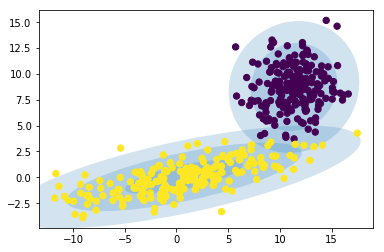

In [129]:
plot_gmm(gmm,np.array(df.loc[:,[comp1,comp2]]))

In [130]:
# display predicted scores by the model as a contour plot
xlist = np.linspace(df[comp1].max()-1, df[comp1].max()+1)
ylist = np.linspace(df[comp1].max()-1, df[comp1].max()+1)

xx, yy = np.meshgrid(xlist, ylist) 
plt.figure()

zz = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(yy.shape[1]):
        zz[i,j] = multivariate_gaussian([xx[i,j], yy[i,j]],mu,covariance)

NameError: name 'mu' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
# display predicted scores by the model as a contour plot
x = np.linspace(df[comp1].max()-1, df[comp1].max()+1)
y = np.linspace(df[comp1].max()-1, df[comp1].max()+1)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = gmm.score(XX)
Z = Z.reshape(X.shape)


In [ ]:
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(df.loc[:,comp1], df.loc[:, comp2], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

In [ ]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

In [ ]:
gmm2 = mixture.GaussianMixture(n_components=2, covariance_type='full')
plot_gmm(gmm2, Xmoon)